In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import pysindy as ps
from torch.utils.data import DataLoader, TensorDataset
from functions import Solution, Rossler, plot
from models import Autoencoder, integrator, network
from dynamical_models import PolySindyModel
import torch.nn.functional as F

In [71]:
a, b, c = 0.15, 0.2, 10
h = np.pi/100
t = np.arange(0,100,h)
n = len(t)
x0 =[0.1,1,0.1]
xs,ys,zs = Solution(Rossler, x0, t, [a,b,c])
tau = 17

sol = Solution(Rossler, x0, t, [a,b,c])
library = ps.PolynomialLibrary(degree=2)
model = ps.SINDy(feature_library=library,
                 optimizer=ps.STLSQ(threshold=0.05),
                 feature_names=["x", "y", "z"])

model.fit(sol.T, t)
model.print()

rossler_coefs = model.coefficients()

(x)' = -1.000 y + -0.998 z
(y)' = 1.000 x + 0.150 y
(z)' = 0.199 1 + -9.938 z + 0.994 x z


In [72]:
psindy = PolySindyModel(n_dimensions=3, degree=2, include_interaction=True, interaction_only=False, include_bias=True, mask=None)
system = psindy.poly_system
X = odeint(system, x0, t, args = (rossler_coefs,))
x_input = X[:,0]
layer_dims = [3, 100, 40, 10, 3]
tstep_pred = 40

In [73]:
ode_model = integrator(tstep_pred, np.pi/100, system=system, init_params=np.zeros_like(rossler_coefs)) # initiating parameters with 0s
encoder = network(layer_dims=layer_dims, activation= F.elu)
decoder = network(layer_dims=layer_dims[::-1], activation=F.elu)

optim_enc = torch.optim.Adam(encoder.parameters(), lr = 1e-3)
optim_ode = torch.optim.Adam(ode_model.parameters(), lr = 1e-2)
loss_fn = nn.MSELoss()

In [74]:
v1 = np.array(x_input[0: n - 2*tau]) #x(t)
v2 = np.array(x_input[tau: n - tau]) #x(t + τ)
v3 = np.array(x_input[2*tau: n]) #x(t + 2τ)

dv1 = np.gradient(v1, t[:len(v1)])
dv2 = np.gradient(v2, t[:len(v1)])
dv3 = np.gradient(v3, t[:len(v1)])

v = torch.tensor(np.array([v1, v2, v3]), dtype=torch.float32, requires_grad=True).T
dvdt = torch.tensor(np.array([dv1, dv2, dv3]), dtype=torch.float32, requires_grad=True).T
dataset = TensorDataset(v, dvdt)
dataloader = DataLoader(dataset, batch_size=1500, shuffle=False)

In [75]:
torch.manual_seed(123)

In [76]:
sindyae = Autoencoder(tau, ode_model=ode_model, loss_fn=loss_fn, optim_enc=optim_enc, optim_ode=optim_ode, tstep_pred=tstep_pred,
                                  encoder=encoder, decoder=decoder,
                                  l={'x0':1, 'cons': 1, 'l1': 1e-1, 'recon': 1e-1, 'x_dot': 1e-1, 'v_dot': 1e-1})

In [77]:
for epoch in range(100):
    total_loss = 0
    for v_batch, dvdt_batch in dataloader:
        Loss = sindyae.loss(v_batch, dvdt_batch)
        Loss.backward()
        optim_enc.step()
        optim_ode.step()
        optim_enc.zero_grad()
        optim_ode.zero_grad()
        total_loss += Loss.item() 
    average_loss = total_loss / len(dataloader)
    if (epoch+1) % 10== 0:
         print(f"Epoch [{epoch+1}/{100}], Loss: {average_loss:.4f}")

Epoch [10/100], Loss: 50.5966
Epoch [20/100], Loss: 54.7811
Epoch [30/100], Loss: 30.0380
Epoch [40/100], Loss: 23.1239
Epoch [50/100], Loss: 22.9776
Epoch [60/100], Loss: 25.1129
Epoch [70/100], Loss: 25.3588
Epoch [80/100], Loss: 32.0839
Epoch [90/100], Loss: 22.1858
Epoch [100/100], Loss: 19.2528


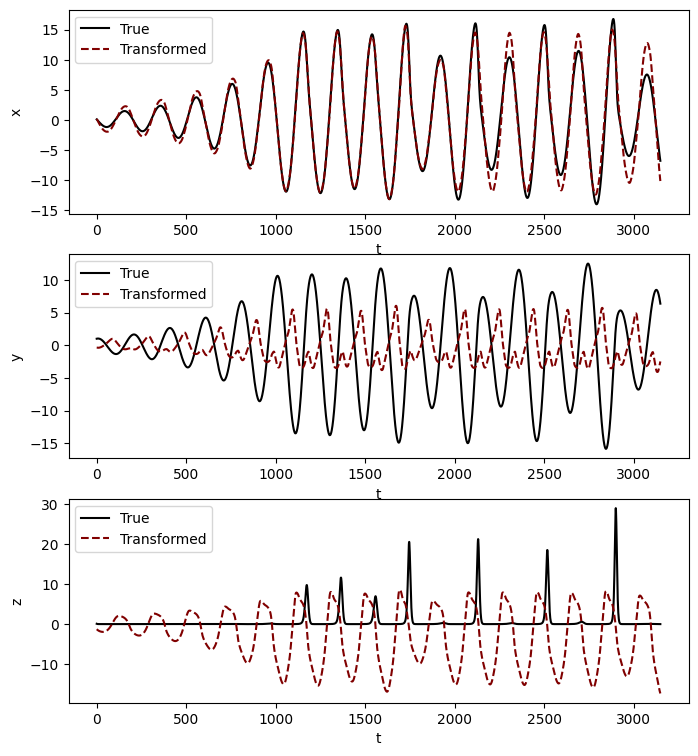

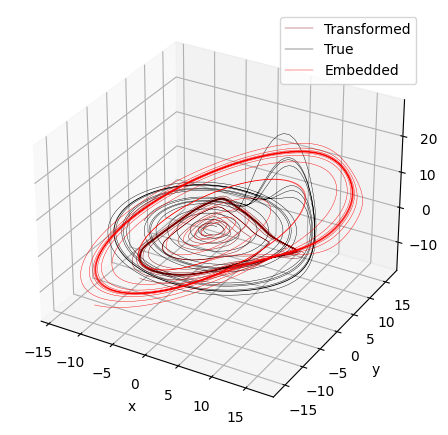

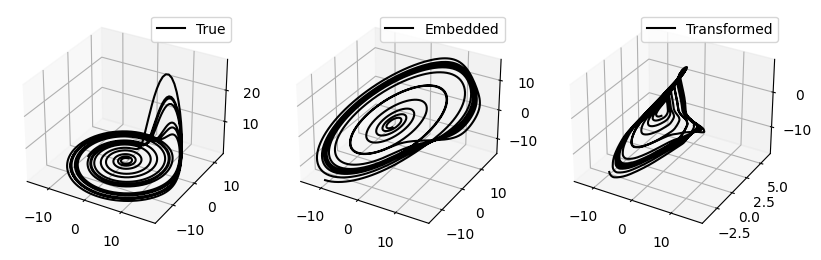

In [78]:
encoder.eval() 
ode_model.eval()
latent_variables = encoder(v)
x_ae = latent_variables[:,0].detach().numpy()
y_ae = latent_variables[:,1].detach().numpy()
z_ae = latent_variables[:,2].detach().numpy()

plot(xs, ys, zs, v1, v2, v3, x_ae, y_ae, z_ae)

(x)' = 2.835 1 + -1.693 x + -1.723 y + 1.812 z + 0.385 y^2 + -0.182 y z
(y)' = -0.401 1 + -0.063 x + -0.644 y + -0.612 z + 0.085 x^2 + 0.452 x y + 0.450 y^2 + -0.267 y z + -0.076 z^2
(z)' = -0.716 x + 1.891 y + 0.504 z + -0.155 x^2 + -0.900 x y + 0.232 x z + -0.505 y^2 + 0.612 y z + -0.079 z^2


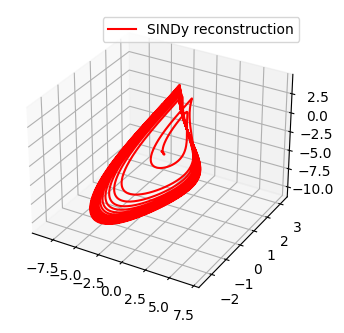

In [86]:
latent_library = ps.PolynomialLibrary(degree = 2)
latent_model = ps.SINDy(feature_library=latent_library,
                        optimizer=ps.STLSQ(threshold=0.05),
                        feature_names=["x", "y", "z"])
latent_model.fit(latent_variables.detach().numpy(), t[:len(latent_variables.detach().numpy())])
latent_model.print()
latent_coef = latent_model.coefficients()
latent_sol = odeint(system, latent_variables[0].detach().numpy(), t, args = (latent_coef,))
fig = plt.figure(figsize=(13, 13))
ax3d = fig.add_subplot(1, 3, 1, projection='3d')
ax3d.plot(latent_sol[:,0], latent_sol[:,1], latent_sol[:,2], color ='r', label = "SINDy reconstruction")
plt.legend()
plt.show()